In [1]:
import datetime
from argparse import ArgumentParser
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix
import pickle
import sys
import os
from astropy.table import QTable, Table
from astropy.io import ascii
from glob import glob
from scipy import stats
from itertools import chain
from corner import corner
from collections import Counter

now = datetime.datetime.now()
date = str(now.strftime("%Y-%m-%d"))

In [2]:
def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

In [3]:
meta = Table.read('meta_all.csv',format='ascii')

In [4]:
params = {idd: {'ddf_bool':row['ddf_bool'], 'hostgal_photoz':row['hostgal_photoz'], 
                'hostgal_photoz_err':row['hostgal_photoz_err'], 'true_z':row['true_z']} 
          for idd, row in zip(meta['object_id'].value,meta)}

In [90]:
feat_train = np.load('features/feat_train.npz', allow_pickle=True)
train_counts = Counter([idd.split('_')[0] for idd in feat_train['ids']])
clf = IsolationForest(n_estimators=1000, max_features=1, max_samples=256,bootstrap=True,random_state=0)
clf.fit(feat_train['features'])

IsolationForest(bootstrap=True, max_features=1, max_samples=256,
                n_estimators=1000, random_state=0)

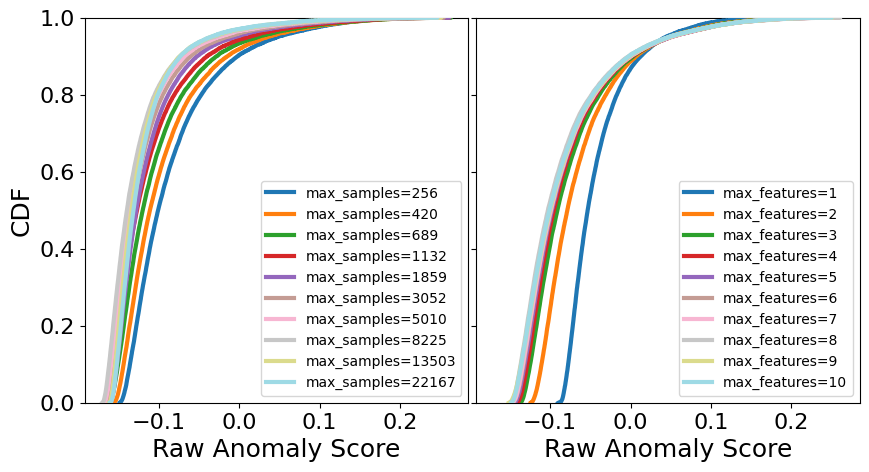

In [104]:
fig, axes = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0.02)

cmap = cm.get_cmap('tab20', 10)
colors = cmap(np.linspace(0, 1, 10))

for i, max_s in enumerate(np.logspace(np.log10(256),np.log10(len(feat_train['ids'])),10)):
    clf_test = IsolationForest(n_estimators=1000, max_samples=int(max_s),bootstrap=True,random_state=0)
    clf_test.fit(feat_train['features'])
    score_test = -1*clf_test.decision_function(feat_train['features'])
    norm = np.sort(score_test)
    axes[0].step(np.concatenate([norm,norm[[-1]]]), np.arange(norm.size+1)/float(norm.size),
             linewidth=3,zorder=10, color=colors[i],label=f'max_samples={int(max_s)}')

cmap = cm.get_cmap('tab20', 10)
colors = cmap(np.linspace(0, 1, 10))

for max_f in np.arange(1,11):
    clf_test = IsolationForest(n_estimators=1000, max_features=max_f,bootstrap=True,random_state=0)
    clf_test.fit(feat_train['features'])
    score_test = -1*clf_test.decision_function(feat_train['features'])
    norm = np.sort(score_test)
    axes[1].step(np.concatenate([norm,norm[[-1]]]), np.arange(norm.size+1)/float(norm.size),
             linewidth=3,zorder=10, color=colors[int(max_f-1)],label=f'max_features={int(max_f)}')

for ax in axes:
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=16)
    ax.set_ylim(0,1)
    ax.set_xlabel('Raw Anomaly Score',fontsize=18)
axes[0].set_ylabel('CDF',fontsize=18)

fig.savefig('/Users/brianhsu/Downloads/isolation_test.pdf', dpi=200,  bbox_inches='tight')

In [91]:
sn_type = []
ids = []
features = []
score_arr = []
for i in range(1,52):
    test_file = glob(f'features/feat_test_{i}.npz')[0]
    feat_test = np.load(test_file, allow_pickle=True)    
    sn_type.append([idd.split('_')[0] for idd in feat_test['ids']])
    ids.append([int(idd.split('_')[-1][2:]) for idd in feat_test['ids']])
    features.append(feat_test['features'])
sn_type = np.array(flatten_chain(sn_type))
ids = np.array(flatten_chain(ids))
IIn_ids = Table.read('plasticc_modelpar_042_SNIIn.csv',format='ascii')['object_id'].value
sn_type[np.nonzero(np.in1d(ids,IIn_ids))[0]]='SNIIn'
inds = np.where(sn_type!='AGN')
no_agn = sn_type[inds]
features = np.vstack(features)
score_arr = -1*clf.decision_function(features)
anomaly_score = (np.argsort(np.argsort(score_arr))+1)/score_arr.size

In [92]:
realizations = []
for i in range(1,11):
    features = []
    for j in range(1,52):
        test_file = glob(f'features/resample_{i}_feat_test_{j}.npz')[0]
        feat_test = np.load(test_file, allow_pickle=True)
        features.append(feat_test['features'])
    features = np.vstack(features)
    score = -1*clf.decision_function(features)
    realization = (np.argsort(np.argsort(score))+1)/score.size
    realizations.append(realization)

In [93]:
full_mcmc = np.vstack((realizations,[anomaly_score]))
anomaly_err = np.std(full_mcmc,axis=0)

In [94]:
total_num = flatten_chain([sn_type,[idd.split('_')[0] for idd in feat_train['ids']]])

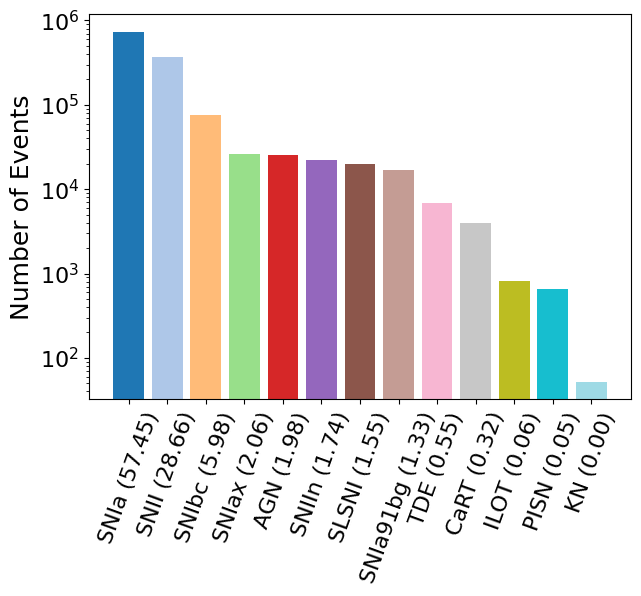

In [109]:
class_num=dict(sorted(Counter(total_num).items()))
fig = plt.figure(figsize=(7,5))
val_sorted = dict(sorted(class_num.items(), key=lambda x: x[1], reverse=True))
order_class = list(val_sorted.keys())
names = [sn+f' ({100*num/len(sn_type):.2f})' for sn, num in zip(list(val_sorted.keys()),list(val_sorted.values()))]
cmap = cm.get_cmap('tab20', len(set(sn_type)))
colors = cmap(np.linspace(0, 1, len(set(sn_type))))
plt.bar(names, list(val_sorted.values()), color=colors,log=True);
plt.xticks(rotation=70);
plt.tick_params(labelsize=16)
plt.ylabel('Number of Events',fontsize=18)
fig.savefig('/Users/brianhsu/Downloads/num_events.pdf', dpi=200,  bbox_inches='tight')

SNIa 0.4865647195041019
SNII 0.47323612425065387
SNIbc 0.5173669454603076
SNIax 0.4660615416958874
AGN 0.7134434387791443
SNIIn 0.6026782702556838
SLSNI 0.9219977909879211
SNIa91bg 0.5885522812599527
TDE 0.6626071363013796
CaRT 0.47689323160581687
ILOT 0.5898266207920124
PISN 0.8922067214840546
KN 0.8117660486767108
SNIa err= 0.0476135288244042
SNII err= 0.03191431429678839
SNIbc err= 0.03333360071979231
SNIax err= 0.038728339345530445
AGN err= 0.011225012115850088
SNIIn err= 0.028233568885972206
SLSNI err= 0.005463883934982705
SNIa91bg err= 0.03880185828237205
TDE err= 0.025945343752224344
CaRT err= 0.027521871318974156
ILOT err= 0.01859549941662785
PISN err= 0.007877394586793117
KN err= 0.011356277888443404


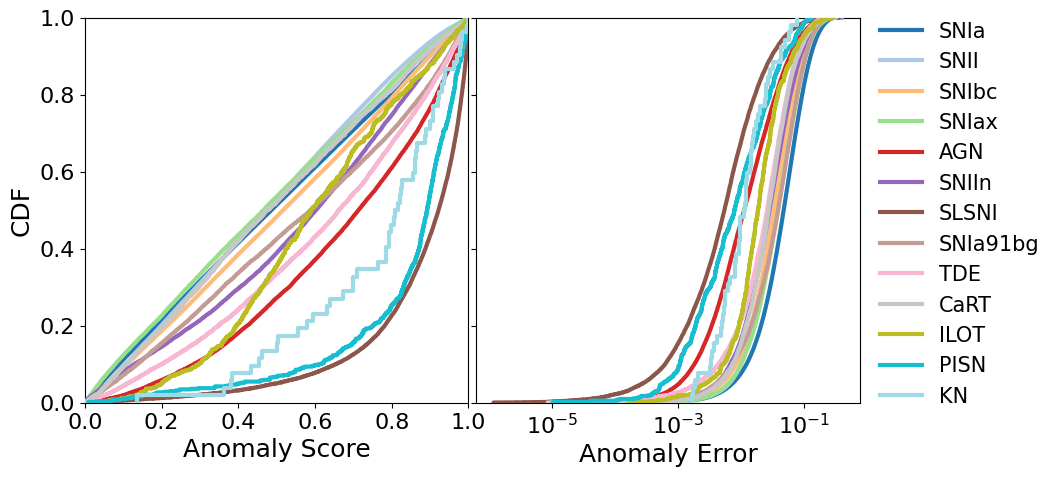

In [125]:
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
plt.subplots_adjust(wspace=0.02)

cmap = cm.get_cmap('tab20', len(set(sn_type)))
colors = cmap(np.linspace(0, 1, len(set(sn_type))))
for i, sn in enumerate(list(val_sorted.keys())):
    inds = np.where(sn_type==sn)
    norm = np.sort(anomaly_score[inds])
    print(sn, np.median(norm))
    axes[0].step(np.concatenate([norm,norm[[-1]]]), np.arange(norm.size+1)/float(norm.size),
             linewidth=3,label=sn,zorder=10, color=colors[i])
    
for i, sn in enumerate(list(val_sorted.keys())):
    inds = np.where(sn_type==sn)
    norm = np.sort(anomaly_err[inds])
    print(sn, 'err=',np.median(norm))
    axes[1].step(np.concatenate([norm,norm[[-1]]]), np.arange(norm.size+1)/float(norm.size),
             linewidth=3,zorder=10, color=colors[i])
fig.legend(loc=9,bbox_to_anchor=(1.,.91),frameon=False,fontsize=15)

for ax in axes:
    ax.tick_params(labelsize=16)
    ax.set_ylim(0,1)
axes[1].set_xscale('log')
axes[0].set_xlim(0,1)
axes[0].set_xlabel('Anomaly Score',fontsize=18)
axes[1].set_xlabel('Anomaly Error',fontsize=18)
axes[0].set_ylabel('CDF',fontsize=18)

fig.savefig('/Users/brianhsu/Downloads/anomaly_score.pdf', dpi=200,  bbox_inches='tight')

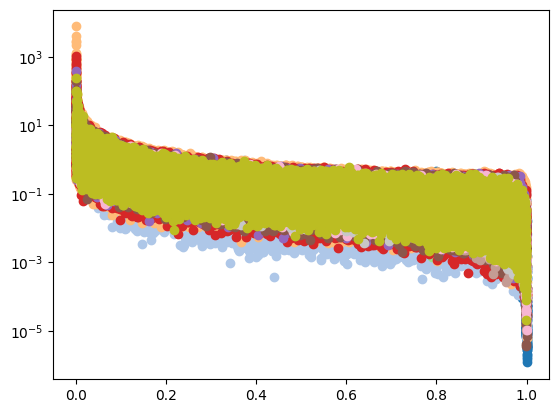

In [138]:
cmap = cm.get_cmap('tab20', len(set(sn_type)))
colors = cmap(np.linspace(0, 1, len(set(sn_type))))
for i, sn in enumerate(list(val_sorted.keys())):
    inds = np.where(sn_type==sn)
    plt.scatter(anomaly_score[inds], (anomaly_err/anomaly_score)[inds], color=colors[i])

plt.yscale('log')

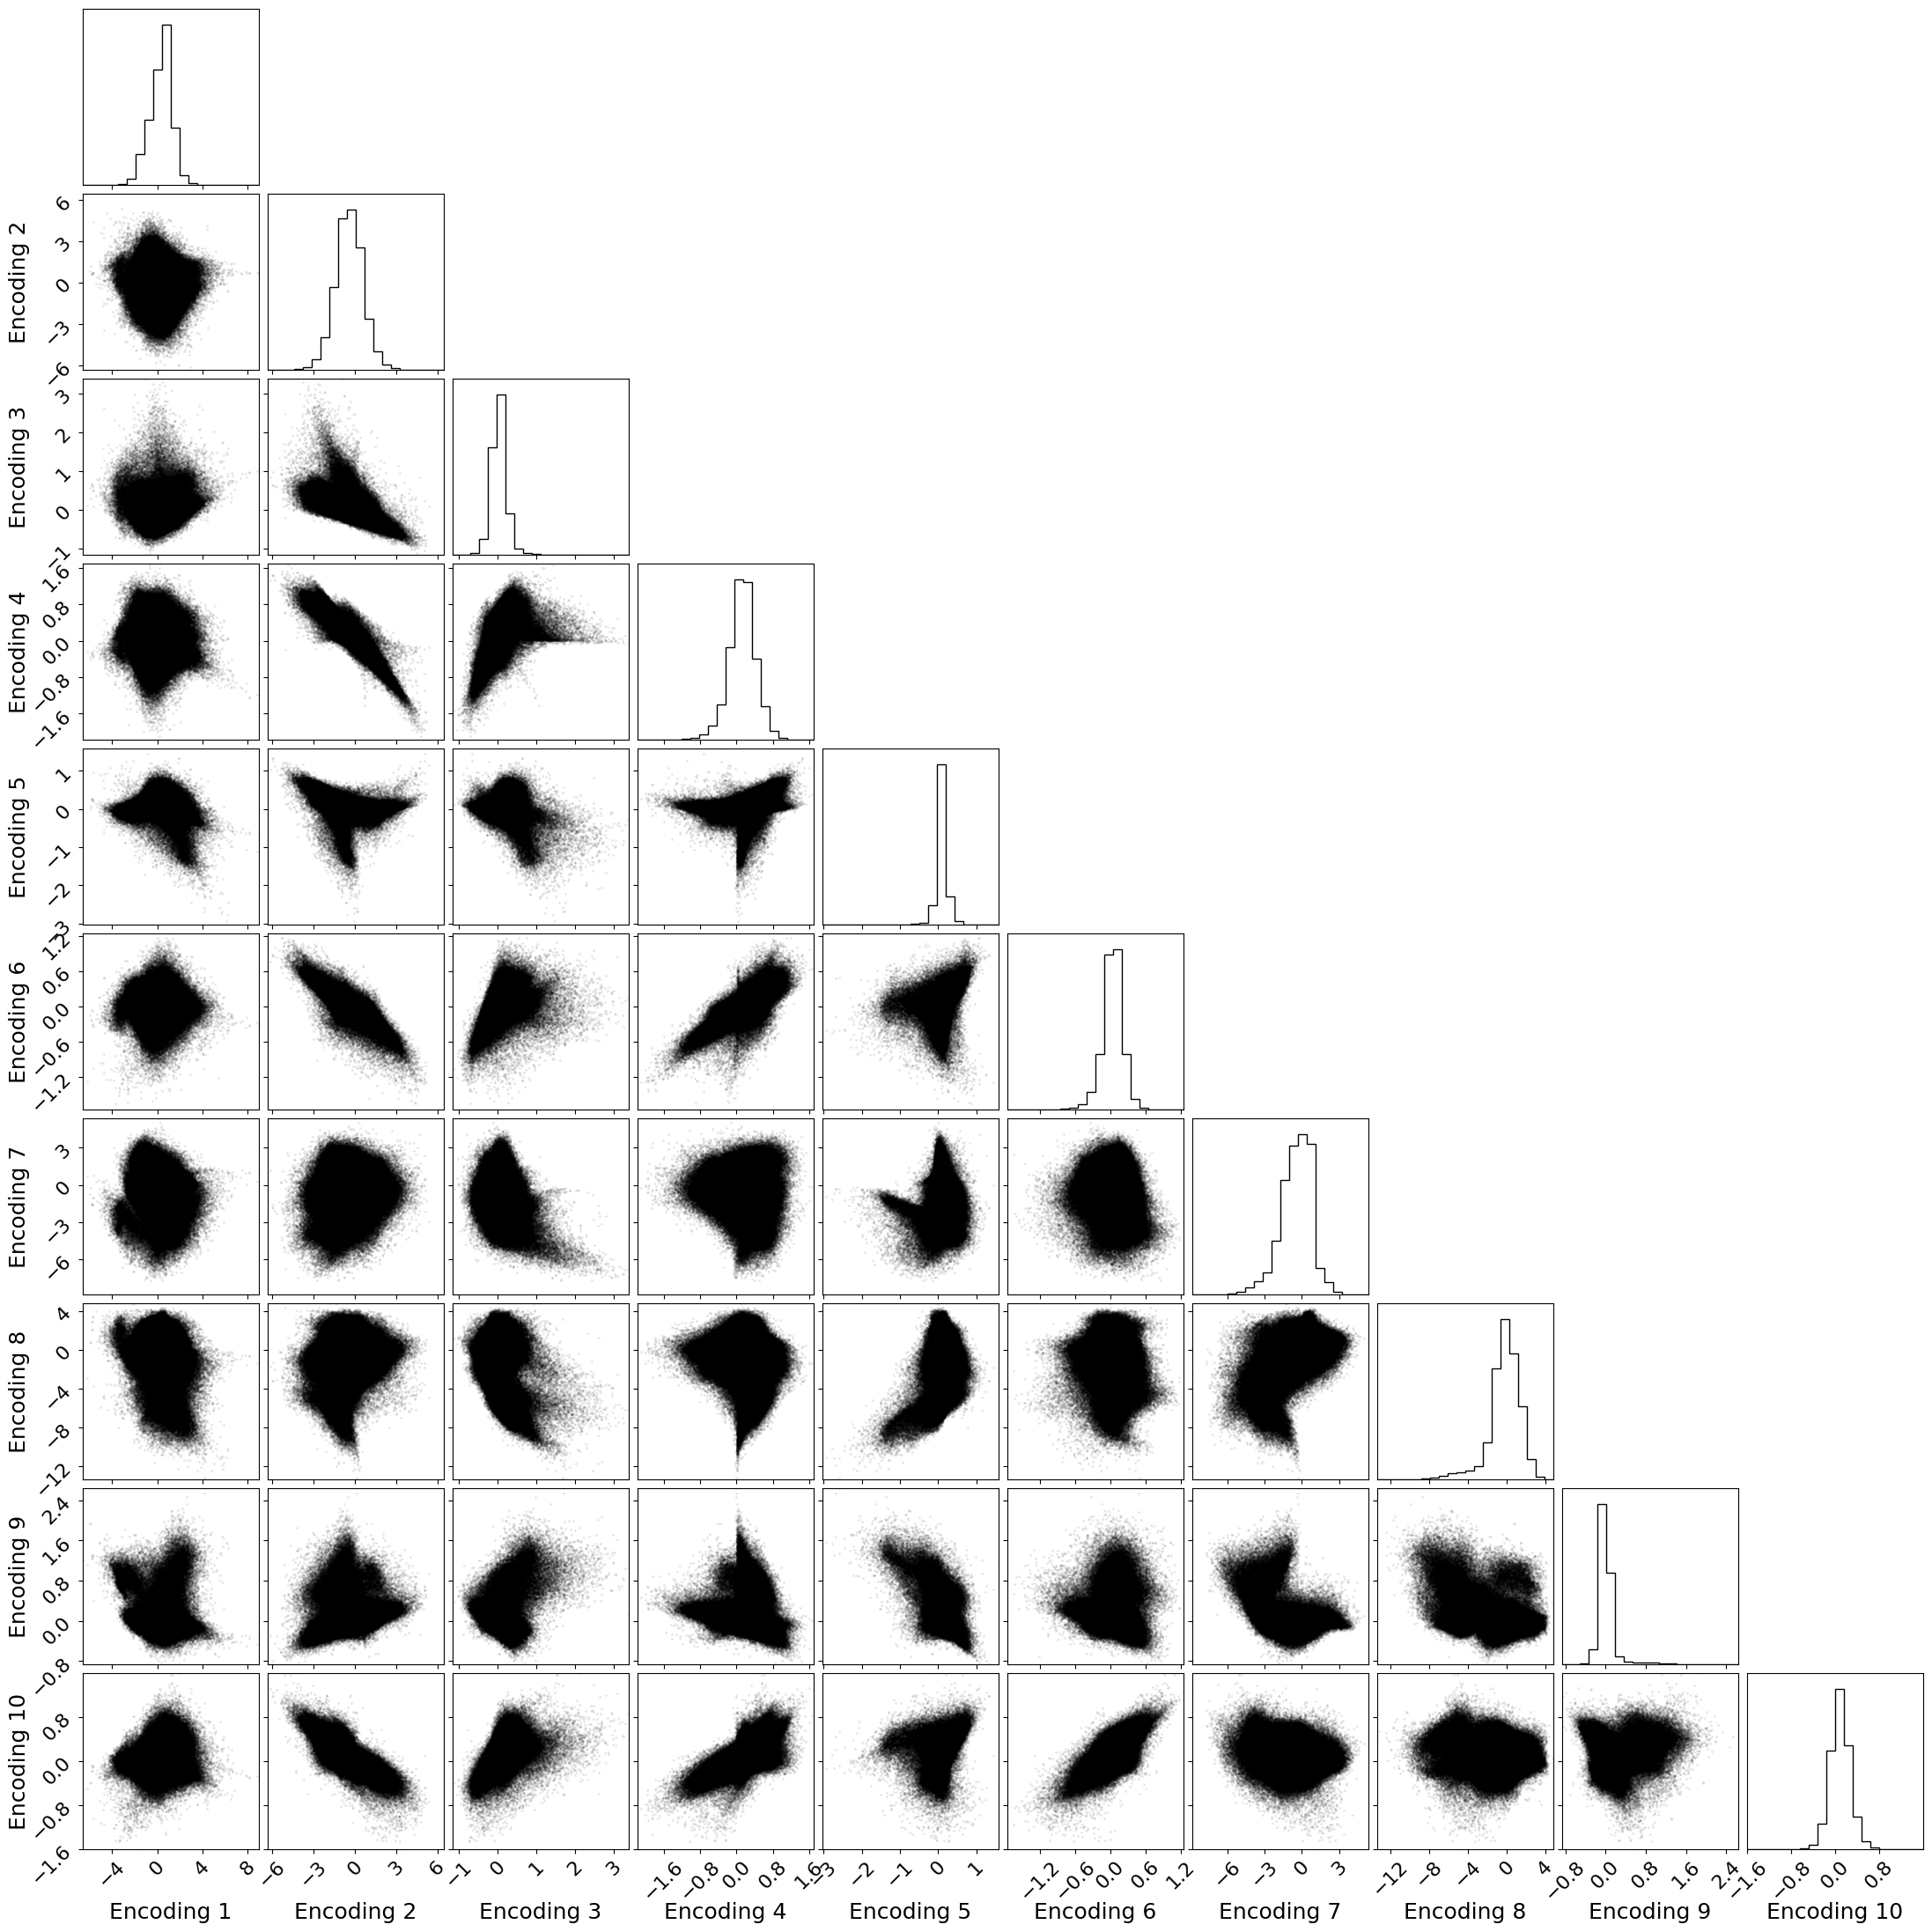

In [54]:
fig = corner(features, plot_density=False, plot_contour=False, no_fill_contours=True,
             quiet=True,alpha=0.1,labels=[f'Encoding {i+1}' for i in range(10)],
             label_kwargs=dict(fontsize=18))
for ax in fig.get_axes():
    ax.tick_params(labelsize=16)
fig.savefig('/Users/brianhsu/Downloads/encodings.pdf', dpi=200,  bbox_inches='tight')

In [152]:
test_num=dict(sorted(Counter(sn_type).items()))

In [153]:
test_num

{'AGN': 24791,
 'CaRT': 3954,
 'ILOT': 803,
 'KN': 52,
 'PISN': 644,
 'SLSNI': 19476,
 'SNII': 358917,
 'SNIIn': 22229,
 'SNIa': 719495,
 'SNIa91bg': 16702,
 'SNIax': 25871,
 'SNIbc': 75009,
 'TDE': 6835}

In [192]:
thresholds = np.logspace(-1,-3.6,80)
fracs = []
for thres in thresholds:
    inds = np.where((anomaly_err/anomaly_score)[z_cut]<thres)
    subset = sn_type[z_cut][inds]
    major = len(np.where(subset == 'SNIa')[0])+len(np.where(subset == 'SNIbc')[0])+len(np.where(subset == 'SNII')[0])
    fracs.append(1-(major/len(subset)))
thres_max = thresholds[np.argmax(fracs)]
inds = np.where((anomaly_err/anomaly_score)[z_cut]<thres_max)
subset = sn_type[z_cut][inds]
counts = Counter(sn_type[z_cut][inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

In [193]:
len(subset)/len(sn_type)

0.0010001741479692934

In [194]:
1-(val_sorted['SNIa']+val_sorted['SNIbc']+val_sorted['SNII'])/len(subset)

0.9050980392156863

In [175]:
(val_sorted['SNIa']+val_sorted['SNIbc']+val_sorted['SNII'])/(test_num['SNIa']+test_num['SNIbc']+test_num['SNII'])

0.00037280403252585133

In [174]:
val_sorted['SLSNI']/(val_sorted['SNIa']+val_sorted['SNIbc']+val_sorted['SNII'])

2.067441860465116

In [166]:
val_sorted['SNII']/test_num['SNII']

0.00037334536954226183

In [168]:
val_sorted['SLSNI']/val_sorted['SNII']

3.91044776119403

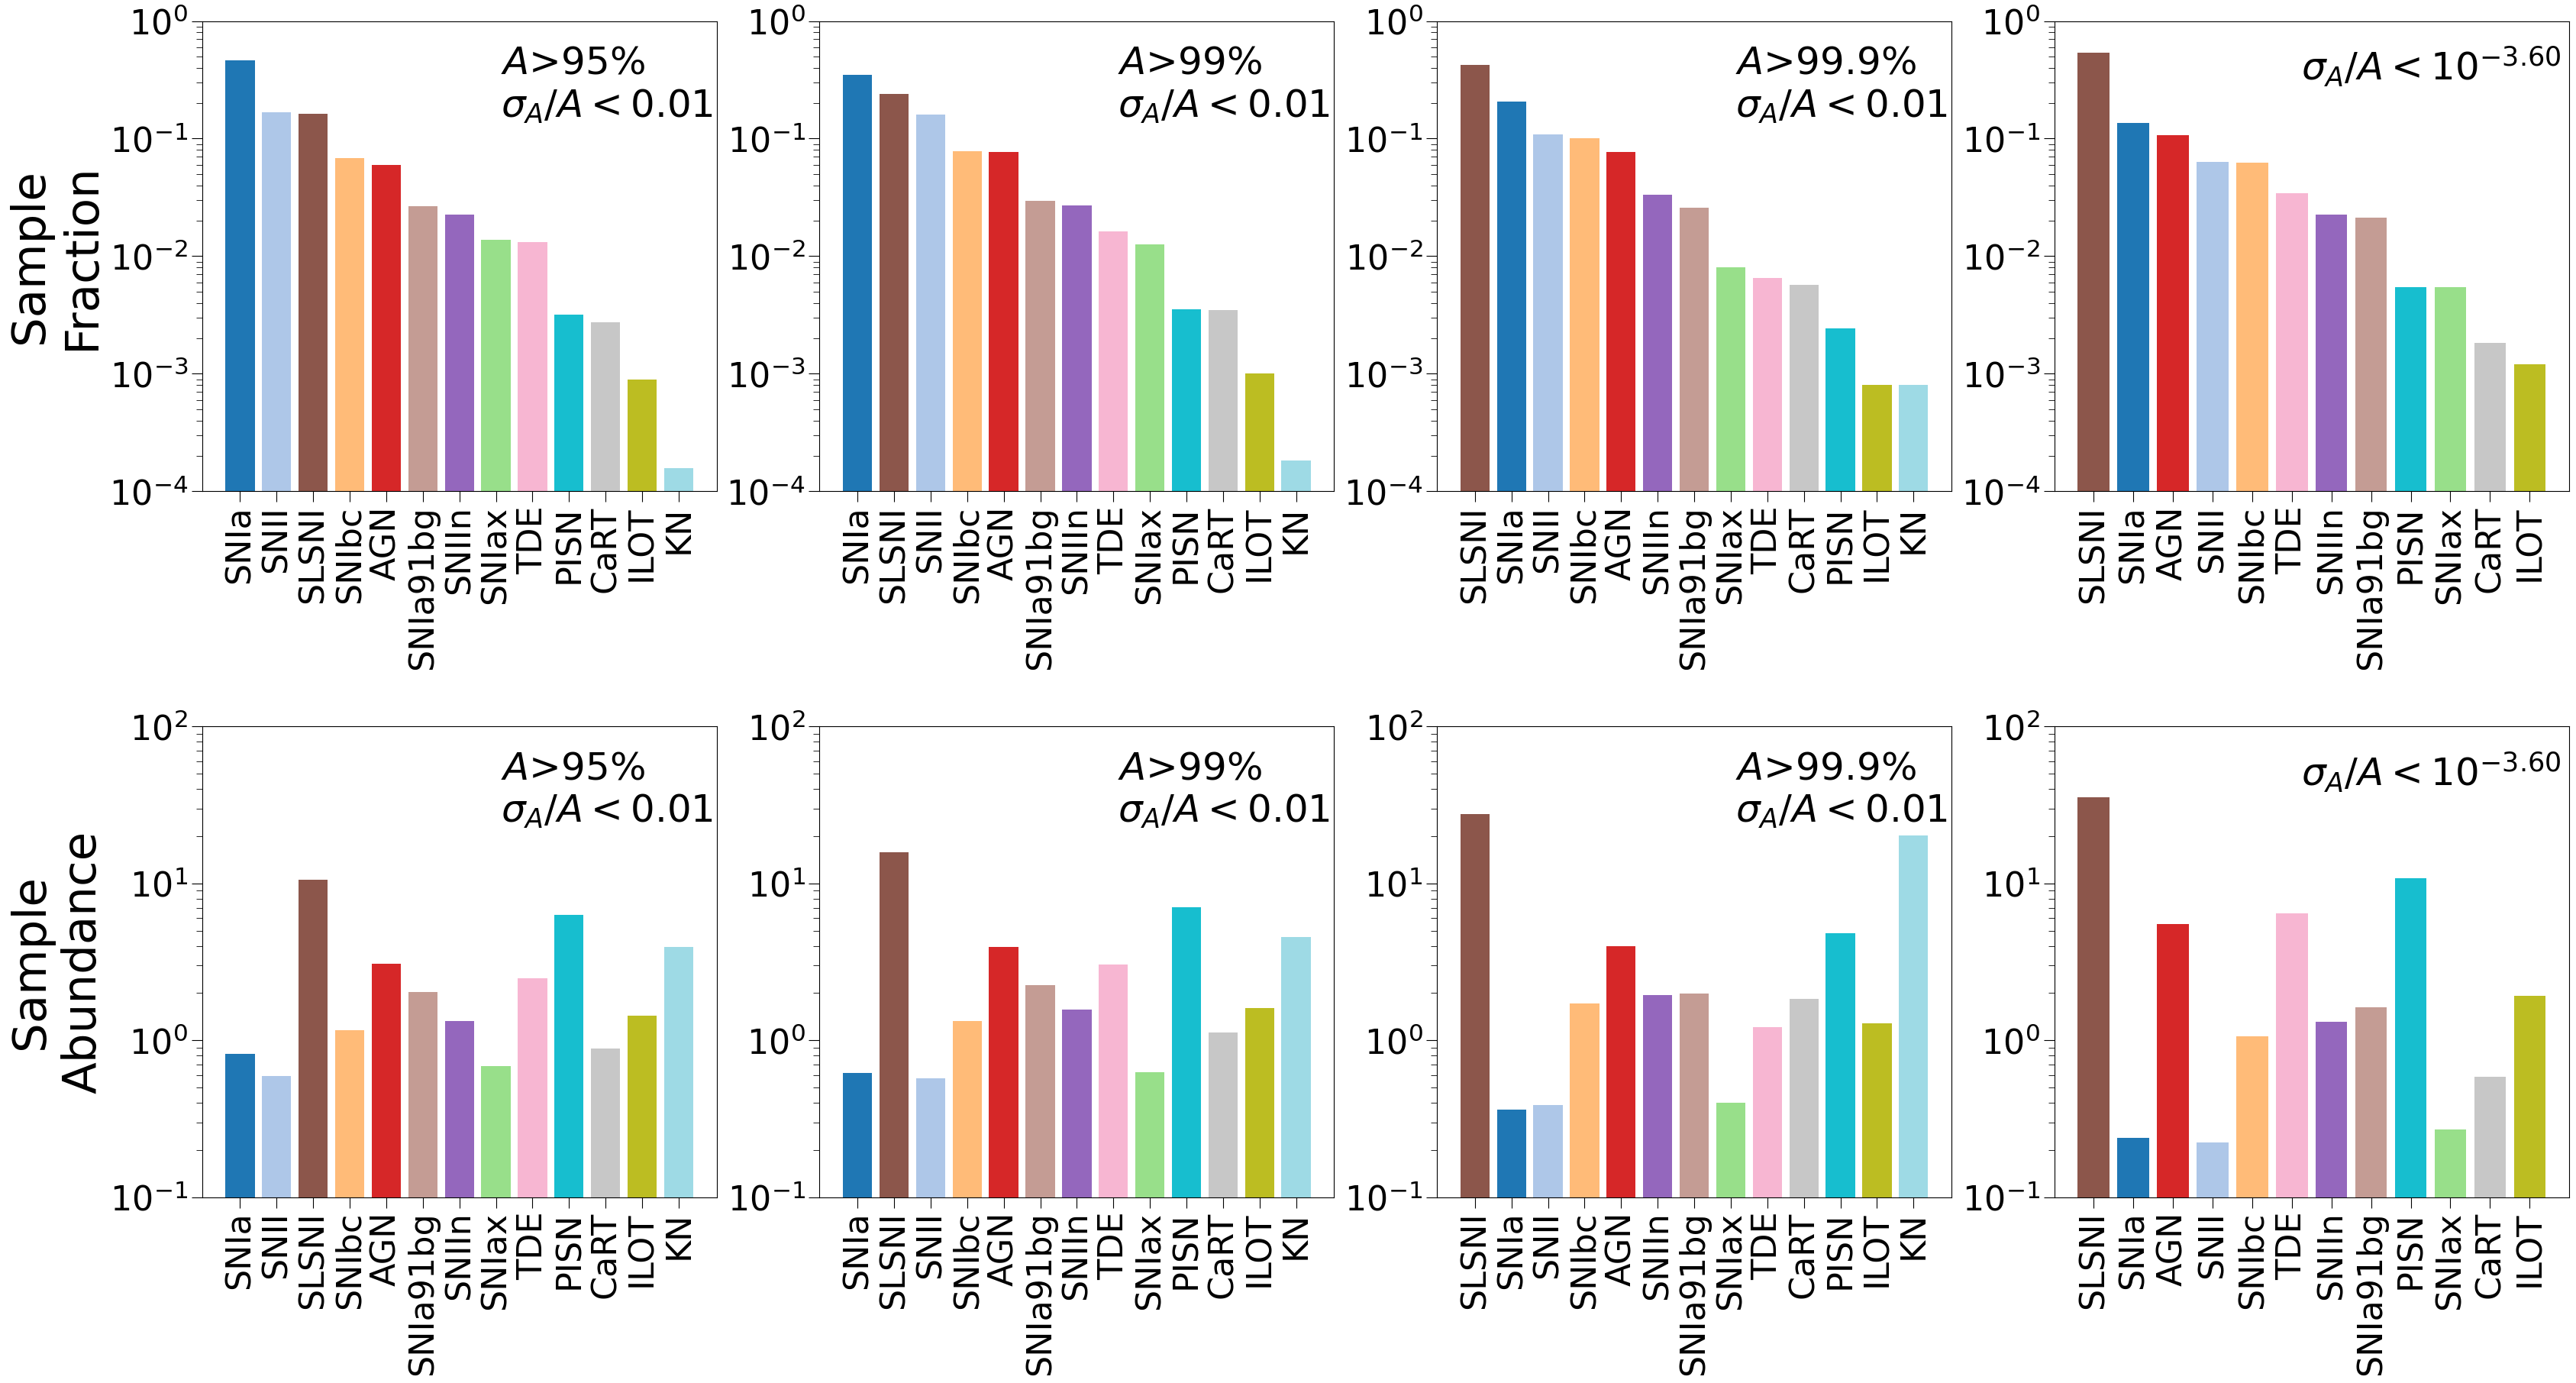

In [150]:
fig, axes = plt.subplots(2,4, figsize=(40,20))
plt.subplots_adjust(hspace=0.5)
cmap = cm.get_cmap('tab20', len(set(sn_type)))
colors = cmap(np.linspace(0, 1, len(set(sn_type))))
color_dict = {sn:color for sn, color in zip(order_class,colors)}

inds = np.where((anomaly_score>0.95)&((anomaly_err/anomaly_score)<0.01))
subset = sn_type[inds]
counts = Counter(sn_type[inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,0].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,0].text(.58, .95, '$A$>95%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[0,0].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,0].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,0].text(.58, .95, '$A$>95%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[1,0].transAxes)

inds = np.where((anomaly_score>0.99)&((anomaly_err/anomaly_score)<0.01))
subset = sn_type[inds]
counts = Counter(sn_type[inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,1].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,1].text(.58, .95, '$A$>99%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[0,1].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,1].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,1].text(.58, .95, '$A$>99%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[1,1].transAxes)

inds = np.where((anomaly_score>0.999)&((anomaly_err/anomaly_score)<0.01))
subset = sn_type[inds]
counts = Counter(sn_type[inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,2].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,2].text(.58, .95, '$A$>99.9%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[0,2].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,2].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,2].text(.58, .95, '$A$>99.9%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[1,2].transAxes)

thresholds = np.logspace(-1,-3.6,80)
fracs = []
for thres in thresholds:
    inds = np.where(anomaly_err/anomaly_score<thres)
    subset = sn_type[inds]
    major = len(np.where(subset == 'SNIa')[0])+len(np.where(subset == 'SNIbc')[0])+len(np.where(subset == 'SNII')[0])
    fracs.append(1-(major/len(subset)))
thres_max = thresholds[np.argmax(fracs)]
inds = np.where((anomaly_err/anomaly_score)<thres_max)
subset = sn_type[inds]
counts = Counter(sn_type[inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,3].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,3].text(.48, .95, '$\\sigma_A/A<10^{'+f'{np.log10(thres_max):.2f}'+'}$', ha='left', va='top',fontsize=36, 
               transform=axes[0,3].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,3].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,3].text(.48, .95, '$\\sigma_A/A<10^{'+f'{np.log10(thres_max):.2f}'+'}$', ha='left', va='top',fontsize=36, 
               transform=axes[1,3].transAxes)

for ax in axes.flatten():
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(labelsize=32,length=10,which='major')
    ax.tick_params(length=6,which='minor')
for ax in axes[0,:]:
    ax.set_ylim(0.0001,1)
for ax in axes[1,:]:
    ax.set_ylim(1e-1,1e2)
axes[0,0].set_ylabel('Sample\nFraction',fontsize=44)
axes[1,0].set_ylabel('Sample\nAbundance',fontsize=44)

fig.savefig('/Users/brianhsu/Downloads/score_cut.pdf', dpi=200,  bbox_inches='tight')

In [185]:
len(z_cut[0])/len(sn_type)

0.9609116253967357

In [181]:
z_arr = np.array([[params[idd]['hostgal_photoz'],params[idd]['true_z']] for idd in ids])
z_ratio = np.abs(z_arr.T[0]-z_arr.T[1])/z_arr.T[1]
z_cut = np.where(z_ratio<2)

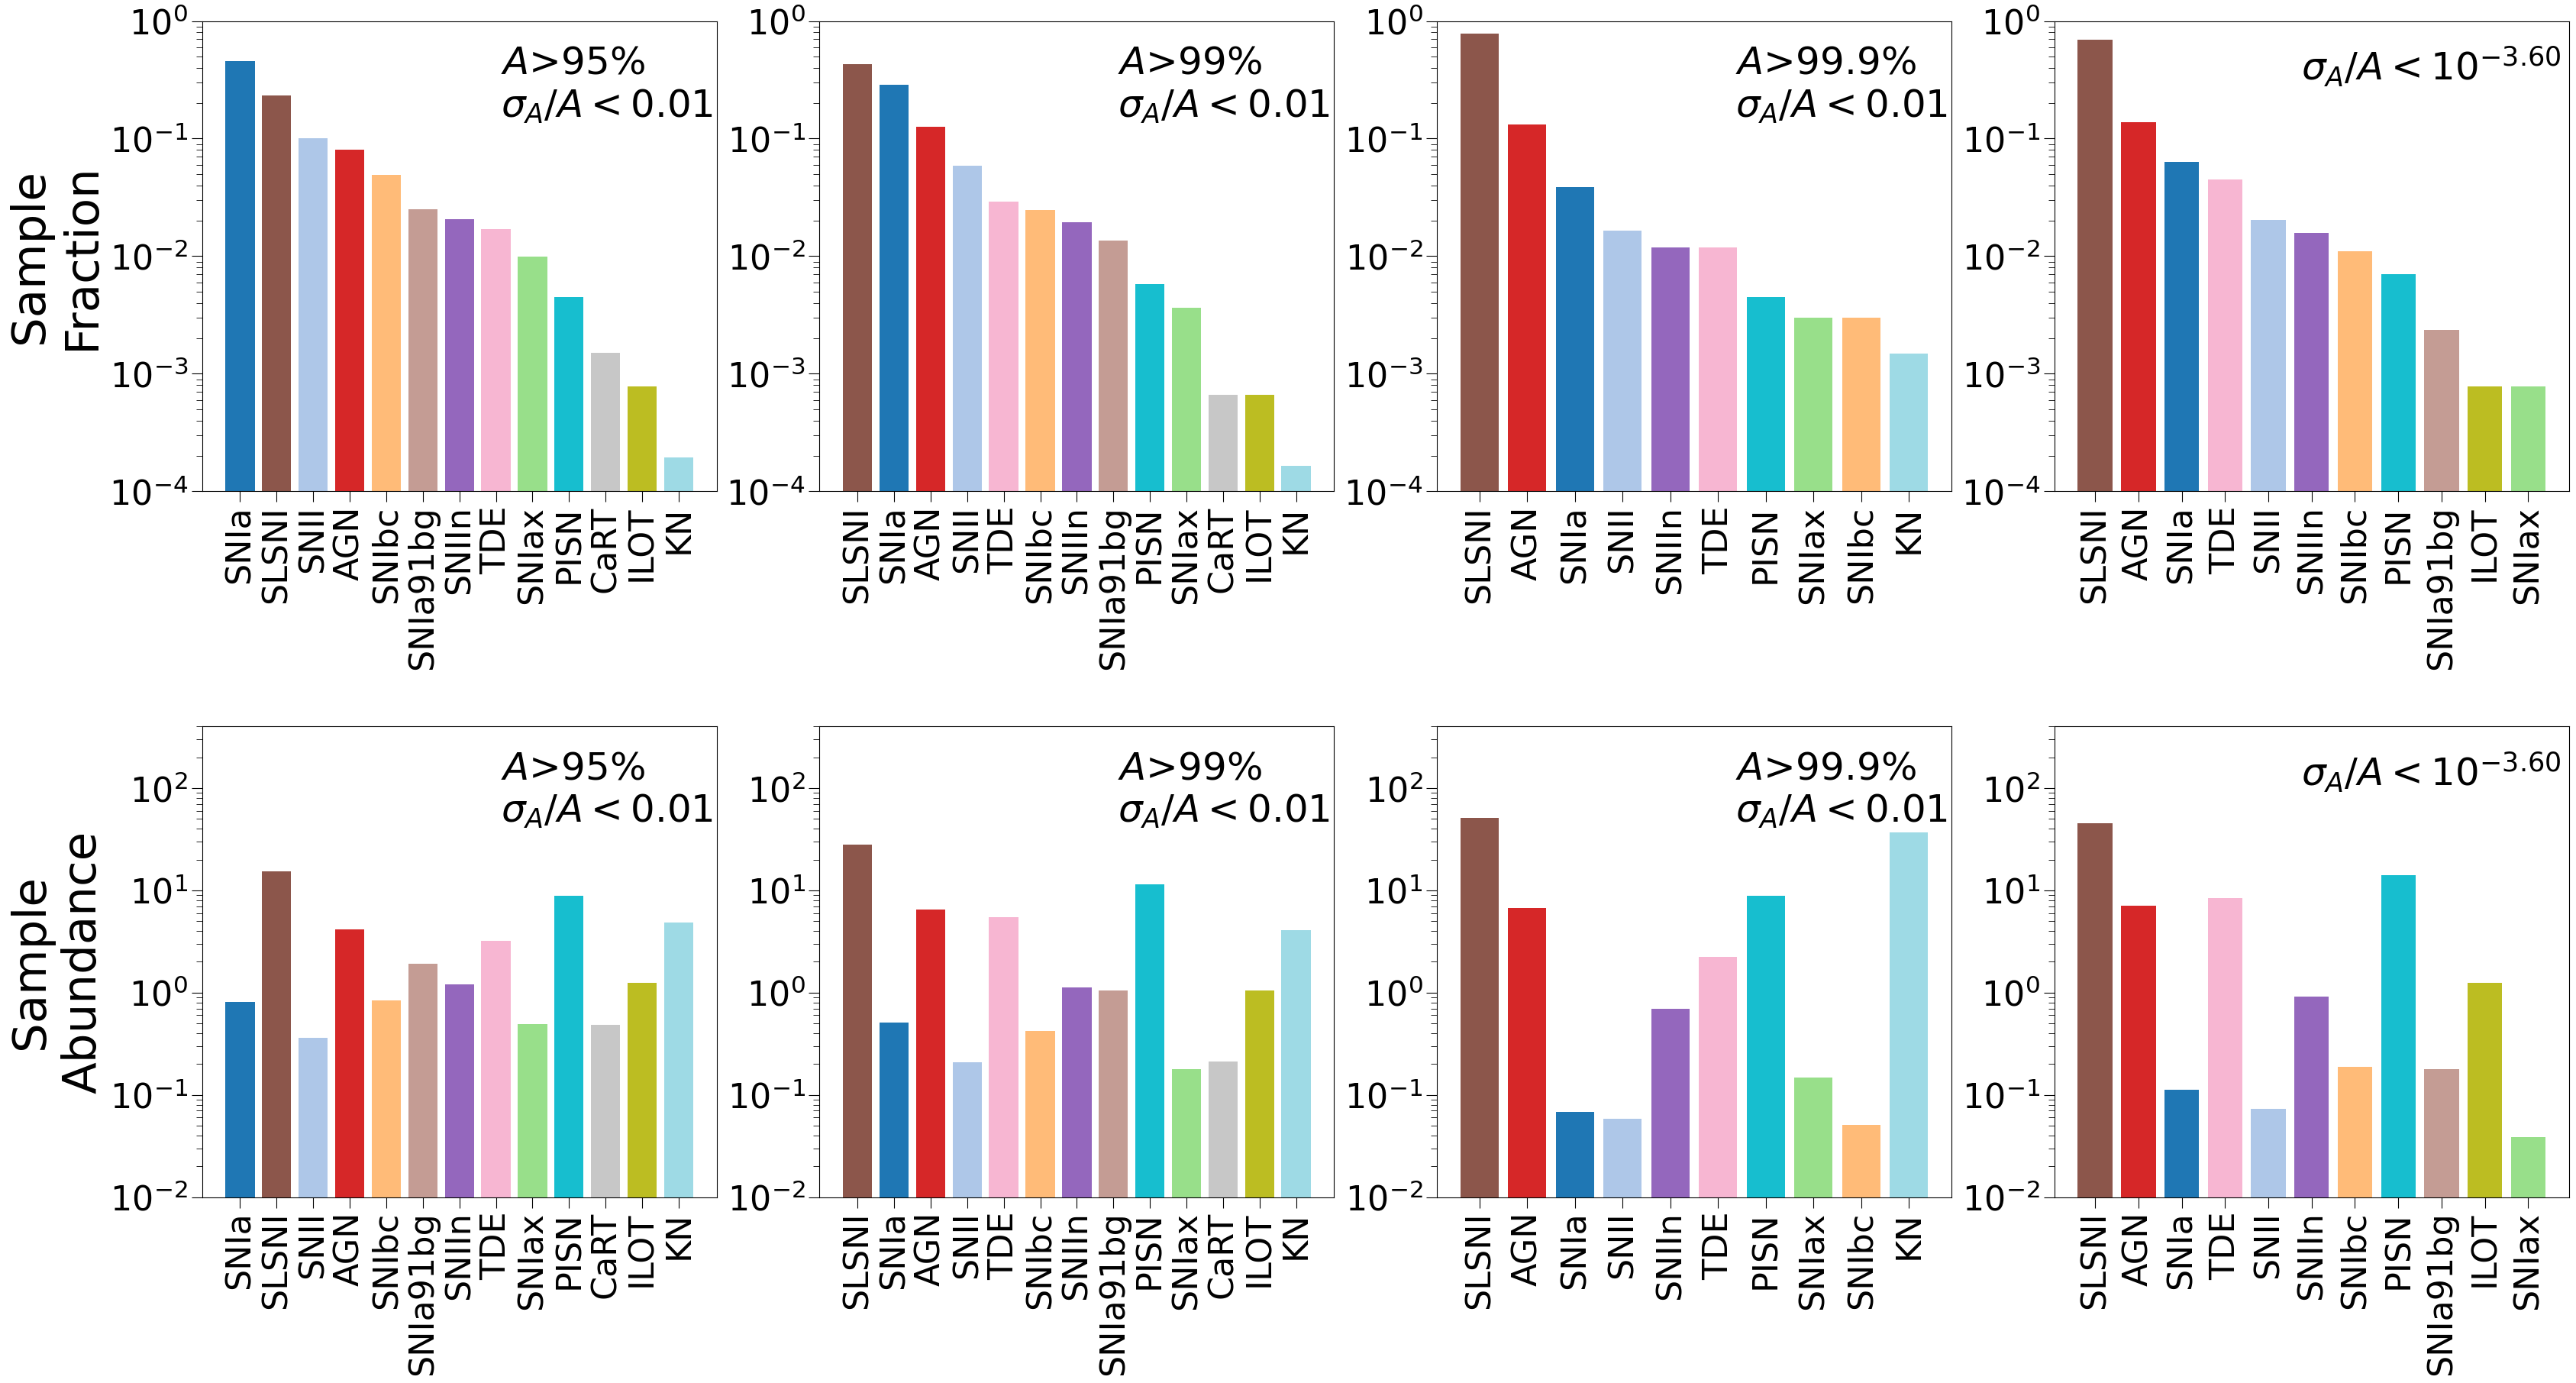

In [182]:
fig, axes = plt.subplots(2,4, figsize=(40,20))
plt.subplots_adjust(hspace=0.5)
cmap = cm.get_cmap('tab20', len(set(sn_type)))
colors = cmap(np.linspace(0, 1, len(set(sn_type))))
color_dict = {sn:color for sn, color in zip(order_class,colors)}

inds = np.where((anomaly_score[z_cut]>0.95)&((anomaly_err/anomaly_score)[z_cut]<0.01))
subset = sn_type[z_cut][inds]
counts = Counter(sn_type[z_cut][inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,0].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,0].text(.58, .95, '$A$>95%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[0,0].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,0].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,0].text(.58, .95, '$A$>95%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[1,0].transAxes)

inds = np.where((anomaly_score[z_cut]>0.99)&((anomaly_err/anomaly_score)[z_cut]<0.01))
subset = sn_type[z_cut][inds]
counts = Counter(sn_type[z_cut][inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,1].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,1].text(.58, .95, '$A$>99%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[0,1].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,1].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,1].text(.58, .95, '$A$>99%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[1,1].transAxes)

inds = np.where((anomaly_score[z_cut]>0.999)&((anomaly_err/anomaly_score)[z_cut]<0.01))
subset = sn_type[z_cut][inds]
counts = Counter(sn_type[z_cut][inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,2].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,2].text(.58, .95, '$A$>99.9%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[0,2].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,2].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,2].text(.58, .95, '$A$>99.9%\n$\\sigma_A/A<0.01$', ha='left', va='top',fontsize=36, 
               transform=axes[1,2].transAxes)


thresholds = np.logspace(-1,-3.6,80)
fracs = []
for thres in thresholds:
    inds = np.where((anomaly_err/anomaly_score)[z_cut]<thres)
    subset = sn_type[z_cut][inds]
    major = len(np.where(subset == 'SNIa')[0])+len(np.where(subset == 'SNIbc')[0])+len(np.where(subset == 'SNII')[0])
    fracs.append(1-(major/len(subset)))
thres_max = thresholds[np.argmax(fracs)]
inds = np.where((anomaly_err/anomaly_score)[z_cut]<thres_max)
subset = sn_type[z_cut][inds]
counts = Counter(sn_type[z_cut][inds])
counts = dict(sorted(counts.items()))
val_sorted = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
axes[0,3].bar(list(val_sorted.keys()), [val/len(subset) for val in val_sorted.values()], 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[0,3].text(.48, .95, '$\\sigma_A/A<10^{'+f'{np.log10(thres_max):.2f}'+'}$', ha='left', va='top',fontsize=36, 
               transform=axes[0,3].transAxes)
abund = [(val_sorted[sn]/sum(list(val_sorted.values())))/(class_num[sn]/sum(list(class_num.values()))) 
         for sn in list(val_sorted.keys())]
axes[1,3].bar(list(val_sorted.keys()), abund, 
              color=[color_dict.get(sn) for sn in list(val_sorted.keys())],log=True)
axes[1,3].text(.48, .95, '$\\sigma_A/A<10^{'+f'{np.log10(thres_max):.2f}'+'}$', ha='left', va='top',fontsize=36, 
               transform=axes[1,3].transAxes)

for ax in axes.flatten():
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(labelsize=32,length=10,which='major')
    ax.tick_params(length=6,which='minor')
for ax in axes[0,:]:
    ax.set_ylim(0.0001,1)
for ax in axes[1,:]:
    ax.set_ylim(1e-2,4e2)
axes[0,0].set_ylabel('Sample\nFraction',fontsize=44)
axes[1,0].set_ylabel('Sample\nAbundance',fontsize=44)

fig.savefig('/Users/brianhsu/Downloads/z_cut.pdf', dpi=200,  bbox_inches='tight')

In [ ]:
class LightCurve(object):
    """Light Curve class
    """
    def __init__(self, name, times, fluxes, flux_errs, filters,
                 zpt=0, mwebv=0, redshift=None, redshift_err=None,
                 lim_mag=None, obj_type=None):

        self.name = name
        self.times = times
        self.fluxes = fluxes
        self.flux_errs = flux_errs
        self.filters = filters
        self.zpt = zpt
        self.mwebv = mwebv
        self.redshift = redshift
        self.redshift_err = redshift_err
        self.lim_mag = lim_mag
        self.obj_type = obj_type

        self.abs_mags = None
        self.abs_mags_err = None
        self.abs_lim_mag = None

    def sort_lc(self):
        gind = np.argsort(self.times)
        self.times = self.times[gind]
        self.fluxes = self.fluxes[gind]
        self.flux_errs = self.flux_errs[gind]
        self.filters = self.filters[gind]
        if self.abs_mags is not None:
            self.abs_mags = self.abs_mags[gind]
            self.abs_mags_err = self.abs_mags_err[gind]

    def find_peak(self, tpeak_guess):
        gind = np.where((np.abs(self.times-tpeak_guess) < 1000.0) &
                        (self.fluxes/self.flux_errs > 3.0))
        if len(gind[0]) == 0:
            gind = np.where((np.abs(self.times - tpeak_guess) < 1000.0))
        if len(gind[0]) == 0:
            tpeak = tpeak_guess
            return tpeak
        if self.abs_mags is not None:
            tpeak = self.times[gind][np.argmin(self.abs_mags[gind])]
        return tpeak

    def cut_lc(self, limit_before=100, limit_after=200):
        gind = np.where((self.times > -limit_before) &
                        (self.times < limit_after))
        self.times = self.times[gind]
        self.fluxes = self.fluxes[gind]
        self.flux_errs = self.flux_errs[gind]
        self.filters = self.filters[gind]
        if self.abs_mags is not None:
            self.abs_mags = self.abs_mags[gind]
            self.abs_mags_err = self.abs_mags_err[gind]

    def shift_lc(self, t0=0):
        self.times = self.times - t0

    def correct_time_dilation(self):
        self.times = self.times / (1.+self.redshift)

    def add_LC_info(self, zpt=27.5, mwebv=0.0, redshift=0.0,redshift_err=0.0,
                    lim_mag=25.0, obj_type='-'):
        self.zpt = zpt
        self.mwebv = mwebv
        self.redshift = redshift
        self.redshift_err = redshift_err
        self.lim_mag = lim_mag
        self.obj_type = obj_type

    def get_abs_mags(self, replace_nondetections=True, mag_err_fill=1.0):
        """
        Convert flux into absolute magnitude

        Parameters
        ----------
        replace_nondetections : bool
            Replace nondetections with limiting mag.

        Returns
        -------
        self.abs_mags : list
            Absolute magnitudes

        Examples
        --------
        """
        lsst_filters = {'0':3740., '1':4870., '2':6250., '3':7700., '4':8900., '5':10845.}
        ext = G23(Rv=3.1)
        reddening = -2.5 * np.log10(ext.extinguish([lsst_filters[str(filt)] for filt 
                                                    in self.filters.astype(int)] * u.AA, 
                                                    Ebv=self.mwebv))
        k_correction = 2.5 * np.log10(1.+self.redshift)
        dist = cosmo.luminosity_distance([self.redshift]).value[0]  # returns dist in Mpc

        self.abs_mags = -2.5 * np.log10(self.fluxes) + self.zpt - 5. * np.log10(dist*1e6/10.0) + k_correction - reddening
        self.abs_mags_err = np.abs((2.5/np.log(10))*(self.flux_errs/self.fluxes))

        if replace_nondetections:
            abs_lim_mag = self.lim_mag - 5.0 * np.log10(dist * 1e6 / 10.0) + k_correction
            gind = np.where((np.isnan(self.abs_mags)) |
                            np.isinf(self.abs_mags) |
                            np.isnan(self.abs_mags_err) |
                            np.isinf(self.abs_mags_err) |
                            (self.abs_mags > self.lim_mag))

            self.abs_mags[gind] = abs_lim_mag
            self.abs_mags_err[gind] = mag_err_fill
        self.abs_lim_mag = abs_lim_mag

        return self.abs_mags, self.abs_mags_err

    def make_dense_LC(self, nfilts=6):
        gp_mags = self.abs_mags - self.abs_lim_mag
        dense_fluxes = np.zeros((len(self.times), nfilts))
        dense_errs = np.zeros((len(self.times), nfilts))
        stacked_data = np.vstack([self.times, self.filters]).T
        x_pred = np.zeros((len(self.times)*nfilts, 2))
        print(self.name)

        pred, pred_var, gp, times = run_gp(self.times, self.filters, gp_mags, self.abs_mags_err)
        pred = pred.T
        pred_var = pred_var.T
        self.gp = [1,2,3]

        dense_fluxes = pred + self.abs_lim_mag
        dense_errs = np.sqrt(pred_var)

        self.dense_lc = np.dstack((dense_fluxes, dense_errs))
        self.dense_times = times

        self.gp_mags = gp_mags
        return gp, gp_mags

In [ ]:
num_points = []
for file in glob('preprocessed_lc/test_lcs*.npz'):
    lightcurves = np.load(file, allow_pickle=True)['lcs']
    num_points.append([len(lightcurve.times) for lightcurve in lightcurves])
num_points = np.array(flatten_chain(num_points))

In [ ]:
feat_time = np.load('features/time_evo_2.npz', allow_pickle=True)
features_time = np.array([feat_time['features'].reshape((13,300,10))[i] for i in range(13)])
score_time = []
for k in range(300):
    train_score = -1*clf.decision_function(features_time[:,k,:])
    score_time.append((np.argsort(np.argsort(train_score))+1)/train_score.size)
score_time = np.array(score_time).T

In [ ]:
lightcurves = np.load('preprocessed_lc/test_lcs_1.npz', allow_pickle=True)['lcs']
names = np.array([lightcurve.name.split('_')[0] for lightcurve in lightcurves])
ids = np.array([lightcurve.name.split('_')[-1][2:] for lightcurve in lightcurves])
names[np.nonzero(np.in1d(ids,IIn_ids))[0]]='SNIIn'
test = []
for sn in sorted(set(names)):
    inds = np.where(names==sn)[0]
    times = [len(lightcurve.times) for lightcurve in lightcurves[inds]]
    argmax = np.argmax(times)
    test.append(lightcurves[inds][argmax])

In [ ]:
correct_score = []
times = [lightcurve.times for lightcurve in test]
dense_times = np.linspace(-100,200,300)
for time, sc in zip(times, score_time):
    correct_score.append(np.interp(time, dense_times, sc))

In [ ]:
cmap = cm.get_cmap('Paired', len(set(sn_type)))
colors = cmap(np.linspace(0, 1, len(set(sn_type))))
for i, (sc, time, typ) in enumerate(zip(correct_score,times,sorted(set(sn_type)))):
    plt.plot(time,sc, color=colors[i],label=typ)
    
plt.legend(loc=9,bbox_to_anchor=(1.25,1.03),frameon=False,fontsize=16)
plt.axhline(0.98,color='k',ls='--')
# plt.xlim(1e-3,1000)
# plt.ylim(0,1)
# plt.xscale('log')
# plt.tick_params(labelsize=16)
# plt.xlabel('Anomaly Score Uncertainty',fontsize=18)
# plt.ylabel('CDF',fontsize=18)